**ANUSHKA GUPTA**
--
**NIT PATNA**
--
**PROBLEM STATEMENT 1**
--

* **DATA AUGEMENTATION**
    1. Back translation
    2. Synonym Swipe
    3. Random deletion
    4. Random Insertion

* **DATA CLEANING**
    1. Removing extra spaces
    2. Removing punctutations
    3. Case normalization
    4. Remvoing stop words
    5. Stemming
    6. Lemmetization

* **CREATION of CORPUS**
* **CREATION OF TF-IDF vector**
* **ENCODING OF CATEGORIES**
* **MODELLING and TRAINING**
* **TESTING AND RESULT**
* **PERFORMANCE ANALYSIS(Precision, Recall, Accuracy, F1 score)**
* **DATA VISUALIZATION** 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import random
!pip install googletrans==4.0.0-rc1

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

import string
from wordcloud import WordCloud

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 55 kB 635 kB/s            
     |████████████████████████████████| 58 kB 2.1 MB/s            
     |████████████████████████████████| 133 kB 4.1 MB/s            
     |████████████████████████████████| 42 kB 832 kB/s             
     |████████████████████████████████| 1.3 MB 9.2 MB/s            
     |████████████████████████████████| 53 kB 1.5 MB/s             
     |████████████████████████████████| 65 kB 2.3 MB/s             
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17415 sha256=5ae8b94c81613f55e2a1a162650a421e1ec552e5aca12744e3e6e73f965801cd
  Stored in directory: /root/.cache/pip/wheels/43/34/00/4fe71786ea6d12314b29037620c36d857e5d104ac2748bf82a
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.13.0
    Uninstalling h11-0.13.0:
      Successfully uninstalled h11-0.13.0
  Attempting uninstall: idna
    Foun

**IMPORTING TRAIN DATA**
------------------------

In [2]:
train_data = pd.read_csv("../input/instabase/data_csv.csv") 
train_data.tail()

,TEXT,TAGS
21,"Any Lender defaulting, as reasonably determine...",Lender Defaulting
22,Lender shall be deemed to be a Defaulting Lend...,Lender Defaulting
23,Defaulting Lender's right to approve or disapp...,Lender Defaulting
24,"""Disinterested Director"" shall mean, with resp...",Other
25,The Borrower and certain lenders and agents ar...,Other


**IMPORTING TEST DATA**
-----------------------

In [3]:
test_data = pd.read_csv('../input/test-data/test_data_csv.csv')
test_data.tail()

,TEXT,TAGS
5,This Assignment and Assumption shall be govern...,Other
6,As soon as practicable after any payment of In...,Indemnification
7,"Non-Defaulting Lender means, at any time, each...",Other
8,Fundco Facility Agreement means the facility a...,Other
9,Notwithstanding any provision of this Agreemen...,Lender Defaulting


**DATA AUGMENTATION**
---------------------

****BACK TRANSLATION****

In [4]:
from googletrans import Translator
t = Translator()
for i in range(26):
    
    sentence = train_data['TEXT'][i]
    to_lang = t.translate(text = sentence, dest = 'hi').text
    back_to_eng = t.translate(text = to_lang, dest = 'en').text
    train_data.loc[len(train_data.index)] = [back_to_eng, train_data['TAGS'][i]] 

****SYNONYM REPLACEMENT****

In [5]:
from nltk.corpus import wordnet

def get_synonyms(word):
    
    synonyms = set()
    
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

In [6]:
from nltk.corpus import stopwords
stop_words = []
for w in stopwords.words('english'):
    stop_words.append(w)

In [7]:
def synonym_replacement(words, n):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence

In [8]:
length = len(train_data)

for i in range(length):
    replacement = synonym_replacement(train_data['TEXT'][i], len(train_data['TEXT'][i].split())/2)
    #print(replacement)
    train_data.loc[len(train_data.index)] = [replacement, train_data['TAGS'][i]] 
    
train_data.tail()

,TEXT,TAGS
99,"whatsoever loaner has been default, as reserve...",Lender Defaulting
100,The loaner will be consider a default option l...,Lender Defaulting
101,"involve this agreement, the rightfulness of th...",Lender Defaulting
102,"""Disclaimed Director"" means, in relative to an...",Other
103,Borri and some lender and agent are the favour...,Other


****RANDOM DELETION****

In [9]:
def random_deletion(words, p):

    words = words.split()
    
    #obviously, if there's only one word, don't delete it
    if len(words) == 1:
        return words

    #randomly delete words with probability p
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    #if you end up deleting all words, just return a random word
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]

    sentence = ' '.join(new_words)
    
    return sentence

In [10]:
length = len(train_data)

for i in range(length):
    replacement = random_deletion(train_data['TEXT'][i],0.25)
    #print(replacement)
    train_data.loc[len(train_data.index)] = [replacement, train_data['TAGS'][i]] 
    
train_data.tail()

,TEXT,TAGS
203,"whatsoever loaner has been default, as reserve...",Lender Defaulting
204,loaner will be consider a default option loane...,Lender Defaulting
205,"involve this agreement, the the loaner will sp...",Lender Defaulting
206,"""Disclaimed Director"" means, in relative any i...",Other
207,Borri and some lender and agent the favour of ...,Other


**RANDOM INSERTION**

In [11]:
def random_insertion(words, n):
    
    words = words.split()
    new_words = words.copy()
    
    for _ in range(n):
        add_word(new_words)
        
    sentence = ' '.join(new_words)
    return sentence

def add_word(new_words):
    
    synonyms = []
    counter = 0
    
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
        
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)

In [12]:
length = len(train_data)

for i in range(length):
    replacement = random_insertion(train_data['TEXT'][i],2)
    #print(replacement)
    train_data.loc[len(train_data.index)] = [replacement, train_data['TAGS'][i]] 
    
train_data.tail()

,TEXT,TAGS
411,"whatsoever loaner has been default, as reserve...",Lender Defaulting
412,loaner will be consider a default option parti...,Lender Defaulting
413,"involve this agreement, the any whatsoever the...",Lender Defaulting
414,"""Disclaimed Director"" means, in inwards relati...",Other
415,Borri and some lender and agent the favour of ...,Other


**DATA CLEANING**
------------------

**REMOVING EXTRA SPACES**

In [13]:
def remove_spaces(text):
    text = ' '.join(filter(None,text.split(' ')))
    return text

train_data['REMOVE_SPACES'] = train_data['TEXT'].apply(lambda x: remove_spaces(x))

**REMOVING PUNCTUATION AND CASE NORMALIZATION**
---

**CREATION OF CORPUS(BAG OF WORDS)**
----------------------

In [14]:
ps = PorterStemmer()
wordnet=WordNetLemmatizer()
first = train_data['TEXT'].tolist()
second = test_data['TEXT'].tolist()
first.extend(second)

corpus = []
for i in range(len(first)):
    review = re.sub('[^a-zA-Z]', ' ', first[i])
    review = review.lower()
    review = review.split()
    review = [wordnet.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

**CREATION OF TF-IDF VECTOR**
-----------------------------
**Term Frequency — Inverse Document Frequency**

In [15]:
tfidf_v = TfidfVectorizer(max_features=2500,ngram_range=(1,3))
X=tfidf_v.fit_transform(corpus).toarray()

**ENCODING CATEGORIES INTO LABEL FOR BOTH TRAINING AND TEST DATA**
-------------------------------------------------------------------

In [16]:
label_encoder = preprocessing.LabelEncoder()
labels = label_encoder.fit_transform(train_data['TAGS'])
y_test = label_encoder.fit_transform(test_data['TAGS'])

**MODELLING**
-------------

**BUILDING RANDOM FOREST CLASSIFIER**

In [17]:
X_train = X[:416]
y_train = labels
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 300, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=300, random_state=0)

**TESTING THE DATA**

In [18]:
X_test = X[416:]
y_pred_pa = classifier.predict(X_test)
print(y_pred_pa)

[4 0 0 1 2 0 1 2 3 0]


**CONFUSION MATRIX**

In [19]:
cm_pa = confusion_matrix(y_test, y_pred_pa) 
cm_pa.view()

array([[2, 0, 0, 0, 0],
       [0, 2, 0, 0, 0],
       [1, 0, 1, 0, 0],
       [1, 0, 1, 1, 0],
       [0, 0, 0, 0, 1]])

**PRINTING THE RESULT**
-----------------------

In [20]:
label_cat = {0:'Governing Law', 1:'Indemnification', 2:'Lender Defaulting', 3:'Other', 4: 'Preamble'}
list = []
for label in y_pred_pa:
    list.append(label_cat[label])
        
result = pd.DataFrame( list, test_data['TEXT'])
result

,0
TEXT,
"Amendment No. 1 dated as of February 4, 2016 (this ""Amendment No. 1""), to the Amendment and Restatement Agreement dated as of January 10, 2016 (the ""Existing Restatement Agreement""), among GGG HOLDING (U.S.) INC., (the ""Borrower""), CGG, a societe anonyme incorporated under the laws of France (""Parent""), the LENDERS from time to time party thereto and SUISSE AG, as Administrative Agent for the Lenders (in such capacity, ""Administrative Agent"") and as Collateral Agent (""Collateral Agent"") for the Lenders.",Preamble
"Subject to the Legal Reservations, (a) the choice of law specified in each Finance Document as the governing law of such Finance Document will be recognized and enforced in its Relevant Jurisdictions and(b) any judgment obtained in New York (or in the jurisdiction of the governing law of such Finance Document) in relation to a Finance Document will be recognized and enforced in its Relevant Jurisdictions.",Governing Law
"This Agreement, and any non-contractual obligations arising out of or in connection with it, shall be governed by, and construed in accordance with, English law.",Governing Law
"Each Lender agrees to indemnify the Administrative Agent and hold it harmless, rateably according to its Applicable Percentage from and against any and all losses, claims, damages, liabilities and related expenses, including the fees, charges and disbursements of any counsel, which may be incurred by or asserted against the Administrative Agent in any way relating to or arising out of the Loan Documents or the transactions therein contemplated.",Indemnification
"Any Lender that (a) has failed to (i) fund all or any portion of its Loans within two Business Days of the date such Loans were required to be funded hereunder (b) has notified any Borrower or the Administrative Agent in writing that it does not intend to comply with its funding obligations hereunder or (c) has failed, within three Business Days after written request by the Administrative Agent or the Company.",Lender Defaulting
"This Assignment and Assumption shall be governed by, and construed in accordance with, the law governing the Credit Agreement.",Governing Law
"As soon as practicable after any payment of Indemnified Taxes or Other Taxes by an Obligor to a Governmental Authority, the Obligor shall deliver to the Administrative Agent the original or a certified copy of a receipt issued by such Governmental Authority evidencing such payment, a copy of the return reporting such payment or other evidence of such payment reasonably satisfactory to the Administrative Agent.",Indemnification
"Non-Defaulting Lender means, at any time, each Lender that is not a Defaulting Lender at such time.",Lender Defaulting
Fundco Facility Agreement means the facility agreement dated on or about the date of this Agreement and made between Fundco and the Initial Lenders (as defined in the Fundco Facility Agreement and including the Borrower) and Devco;,Other


**RECALL,PRECISION,F1 SCORE AND ACCURACY**
---

In [21]:
print(metrics.classification_report(y_test, y_pred_pa, digits=3))

              precision    recall  f1-score   support

           0      0.500     1.000     0.667         2
           1      1.000     1.000     1.000         2
           2      0.500     0.500     0.500         2
           3      1.000     0.333     0.500         3
           4      1.000     1.000     1.000         1

    accuracy                          0.700        10
   macro avg      0.800     0.767     0.733        10
weighted avg      0.800     0.700     0.683        10



------------------------------------------------------------------------------
**INORDER TO RE-RUN THE PROGRAM, PLEASE RESTART THE KERNAL AND THEN RUN ALL**
------------------------------------------------------------------------------

**DATA VISUALIZATION**
---

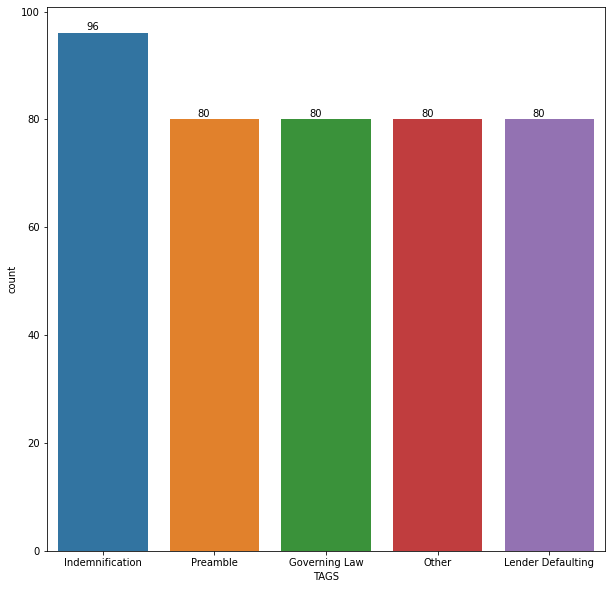

In [22]:
plt.figure(figsize=(10,10))
ax = sns.countplot(x= train_data['TAGS'],  data= train_data, order = train_data['TAGS'].value_counts().index )
for p, label in zip(ax.patches, train_data['TAGS'].value_counts()):   
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.5))

**WORD CLOUD FOR RAW DATA**

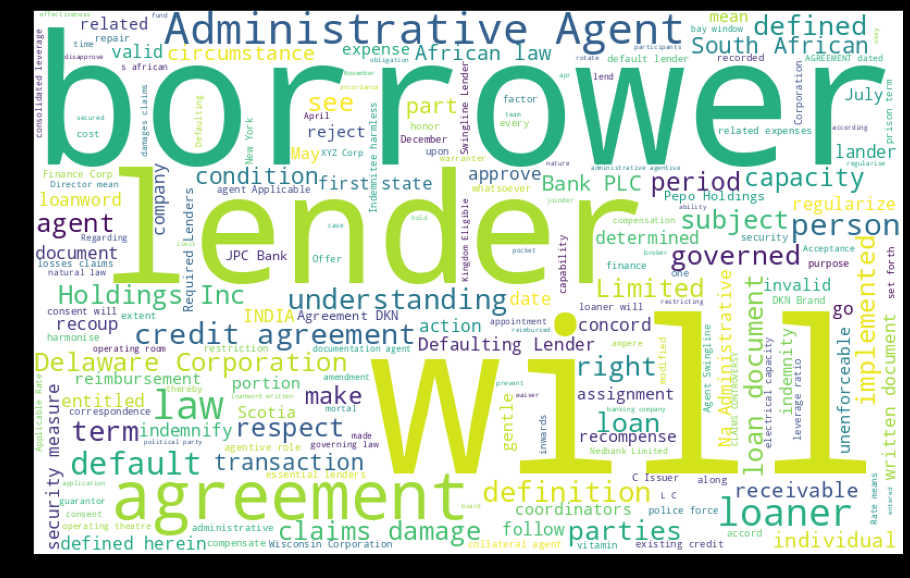

In [23]:
wordcloud = WordCloud(background_color="white",width=800, height=500).generate(' '.join(train_data['TEXT'].tolist()))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)

**WORD CLOUD FOR EACH CLASS**
1. Preamble
2. Indemnification
3. Governing Law
4. Other
5. Lender Defaulting

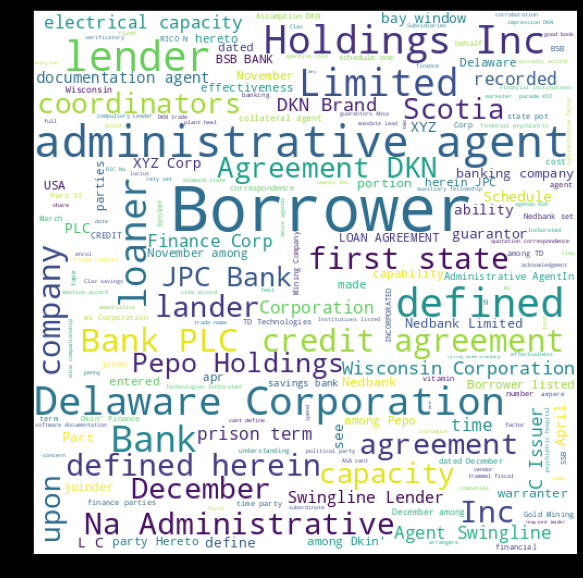

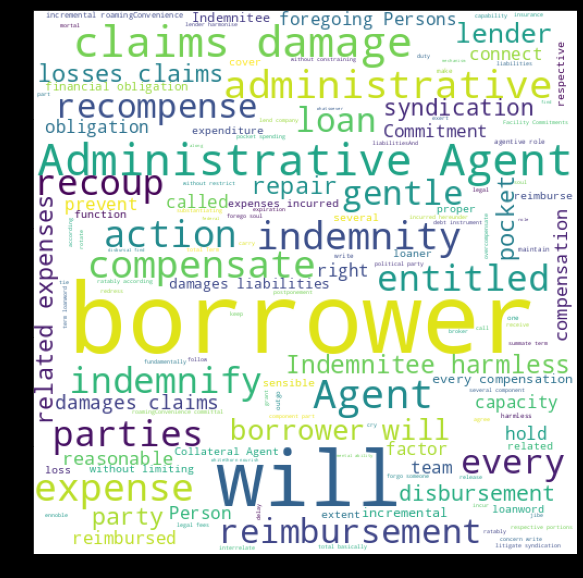

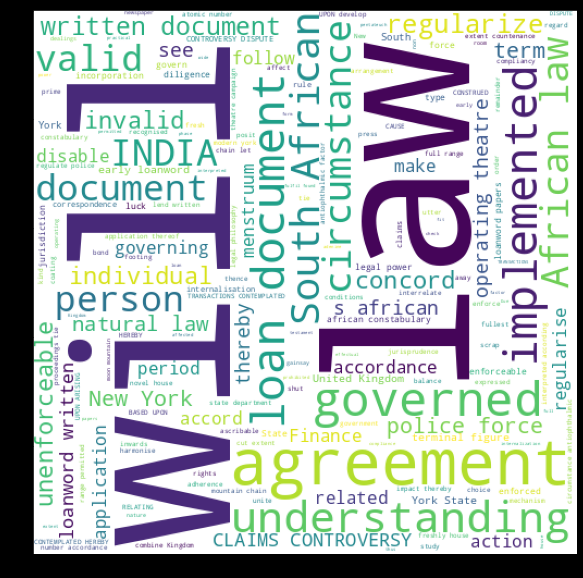

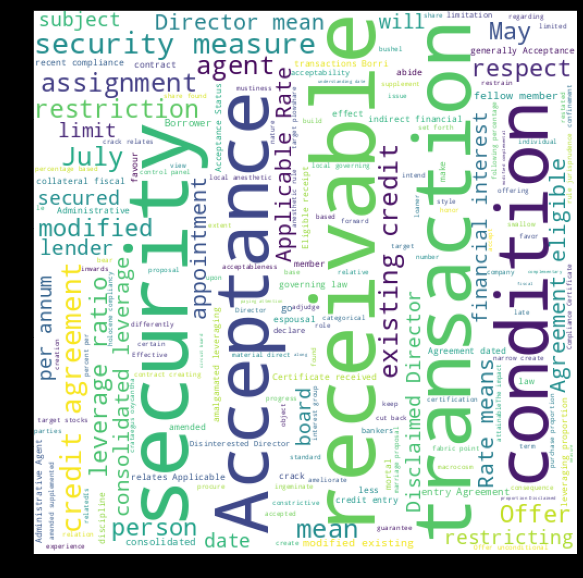

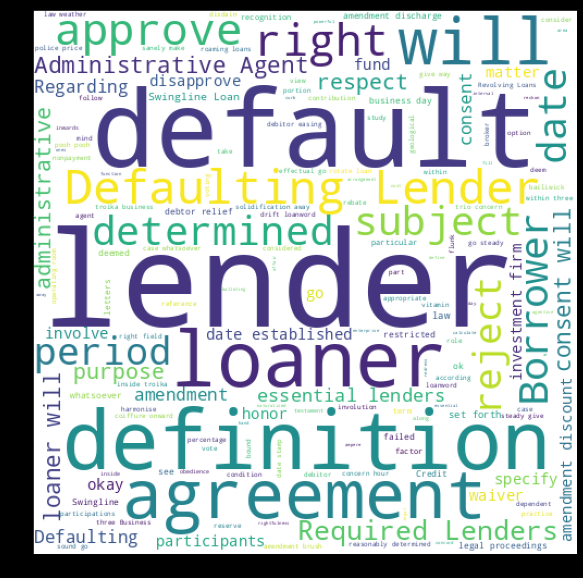

In [24]:
labels = ['Preamble', 'Indemnification', 'Governing Law', 'Other', 'Lender Defaulting']
length = len(train_data)
for label in labels:
    list = []
    for i in range(length):
        if(train_data['TAGS'][i] == label):
            list.append(train_data['TEXT'][i])
    
    wordcloud = WordCloud(background_color="white",width=500, height=500).generate(' '.join(list))
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)        

In [25]:
result.to_csv('result.csv', index=False, encoding='utf-8')

**HYPER-PARAMETER TUNING**
---

**PARAMS IN RANDOM FOREST CURRENTLY IN USE**

In [26]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(classifier.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


**RANDOM HYPERPARAMETER GRID**

In [27]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
#  n_est = 200,400

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_d = 50,60,100
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


**HYPERPARAMETER TUNING USING RANDOM SEARCH**

In [28]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
param_grid = rf_random.best_params_
param_grid

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.1min finished


{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

**GRIDE SEARCH WITH CROSS VALIDATION**

In [29]:
# from sklearn.model_selection import GridSearchCV
# rf = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

# # not working :(